In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from gensim.models import FastText
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

In [3]:
def preprocess_data(file_path):
    texts = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            text, emotion = line.strip().split(';')
            texts.append(text)
            labels.append(emotion)
    return texts, labels

In [5]:
train_texts, train_labels = preprocess_data('/Users/karpagapriyadhanraj/Desktop/EPITA/Action_learning/Sentiment-Analysis/data/train.txt')
test_texts, test_labels = preprocess_data('/Users/karpagapriyadhanraj/Desktop/EPITA/Action_learning/Sentiment-Analysis/data/test.txt')

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

In [7]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)


In [8]:
max_sequence_length = max(len(seq) for seq in train_sequences)
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [9]:
fasttext_model = FastText(sentences=[text.split() for text in train_texts], window=5, min_count=1, workers=4, sg=1)



In [10]:
train_vectors = np.array([np.mean([fasttext_model.wv[word] for word in text.split() if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for text in train_texts])
test_vectors = np.array([np.mean([fasttext_model.wv[word] for word in text.split() if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for text in test_texts])


In [11]:
label_dict = {
    "sadness": 0,
    "joy": 1,
    "anger": 2,
    "fear": 3,
    "love": 4,
    "surprise": 5
}
train_labels_numeric = np.array([label_dict[label] for label in train_labels])
test_labels_numeric = np.array([label_dict[label] for label in test_labels])

Reference: Class materials 

In [12]:
model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length),
    Bidirectional(LSTM(32)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1521300   
                                                                 
 bidirectional (Bidirection  (None, 64)                34048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1555745 (5.93 MB)
Trainable params: 1555745 (5.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.fit(train_data, train_labels_numeric, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
200/200 [==============================] - 6s 23ms/step - loss: -9.2370 - accuracy: 0.3373 - val_loss: -19.3232 - val_accuracy: 0.3262
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: -34.8880 - accuracy: 0.3373 - val_loss: -50.7342 - val_accuracy: 0.3262
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: -85.1788 - accuracy: 0.3373 - val_loss: -121.9583 - val_accuracy: 0.3262
Epoch 4/10
200/200 [==============================] - 5s 23ms/step - loss: -176.6724 - accuracy: 0.3377 - val_loss: -225.1651 - val_accuracy: 0.3319
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: -297.8201 - accuracy: 0.3893 - val_loss: -340.4178 - val_accuracy: 0.4006
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: -438.1102 - accuracy: 0.4325 - val_loss: -484.2920 - val_accuracy: 0.4409
Epoch 7/10
200/200 [==============================] - 4s 21ms/step - loss: -605.2397 - accuracy: 0.4597 - val_lo

In [14]:
loss, accuracy = model.evaluate(test_data, test_labels_numeric)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 1s 3ms/step - loss: -1192.6147 - accuracy: 0.4790
Test Loss: -1192.61474609375
Test Accuracy: 0.4790000021457672


In [15]:
train_labels_binary = np.array([1 if y > 2 else 0 for y in train_labels_numeric])
test_labels_binary = np.array([1 if y > 2 else 0 for y in test_labels_numeric])


In [16]:
lstm_predictions = model.predict(test_data)
lstm_predictions_binary = np.where(lstm_predictions > 0.5, 1, 0).flatten()

63/63 [==============================] - 1s 3ms/step


In [17]:
lstm_cm = confusion_matrix(test_labels_binary, lstm_predictions_binary)


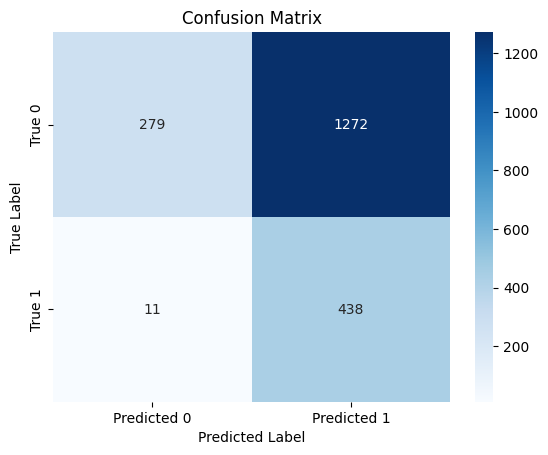

In [18]:
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
model.save('lstm_model.h5')

/Users/karpagapriyadhanraj/miniconda3/envs/my-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
